In [3]:
import tigramite.data_processing as pp
import numpy as np
import warnings
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sortabilitytime.sortnregress_time import (
    var_sort_regress,
    r2_sort_regress_ts,
    r2_sort_regress,
    random_sort_regress_ts,
    random_sort_regress,
    var_sort_regress,
    var_sort_regress_ts,
    ts_graph_to_summary_graph,
)
from sortabilitytime.dynotears import Dynotears
from sortabilitytime.sortability_ts import var_sortability, r2_sortability
import json
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output
import seaborn as sns
sns.set_theme()
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_theme()

In [4]:
def get_adj(links_coeffs, tau_max=None):
    if tau_max == None:
        tau_max = max(
            abs(value[i][0][1])
            for value in links_coeffs.values()
            for i in range(len(value))
        )
    n_vars = len(links_coeffs)
    adj = np.zeros((n_vars, n_vars, tau_max + 1))

    for key, value in links_coeffs.items():
        for i in range(len(value)):
            adj[value[i][0][0], key, abs(value[i][0][1])] = value[i][1]
    return adj

In [5]:
def parse_timeseries_graph(dag, max_lag = None):
    if max_lag == None:
        max_lag = np.max(dag)
    
    timeseries_adj = np.zeros((dag.shape[0], dag.shape[1], max_lag))

    for i in range(1, max_lag):
        adj_t = np.zeros_like(dag)
        adj_t[dag == i] = 1
        timeseries_adj[:, :, i] = adj_t.copy()
    return timeseries_adj

In [ ]:



def get_var_sort(
    n: int,
    data_file: str,
    ground_truth_file: str,
    n_realizations: int,
    standardize=False,
):
    var_sorts = []
    var_sorts_by_lag = []
    f = open(f"{ground_truth_file}")
    truth = json.load(f)
    f.close()
    adj = np.array(truth["truths"])
    adj = adj.reshape(n_realizations, n, n)

    max_lag = np.max(adj)
    if max_lag == 1:
        max_lag = 0
    for i in range(n_realizations):
        df = pd.read_csv(
            f"{data_file}{str(i + 1).zfill(4)}.txt",
            sep=" ",
            names=[i for i in range(n)],
        )
        adj_temp = adj[i].copy()
        np.fill_diagonal(adj_temp, 0)

        if standardize:
            scaler = StandardScaler()
            df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

        timeseries_adj = parse_timeseries_graph(adj_temp, max_lag)
        varsorts_lag_temp = []
        for j in range(max_lag):
            if np.count_nonzero(timeseries_adj[:, :, j]) > 0:
                temp = timeseries_adj[:, :, j].copy()
                varsorts_lag_temp.append(var_sortability(df.to_numpy(), temp))
            else:
                varsorts_lag_temp.append(np.nan)
        temp = adj[i]
        np.fill_diagonal(temp, 0)
        var_sort_temp = var_sortability(df.to_numpy(), temp)
        var_sorts.append(var_sort_temp)
        if max_lag <1:
            varsorts_lag_temp = [var_sort_temp]

        var_sorts_by_lag.append(np.array(varsorts_lag_temp))

    var_sorts_by_lag = np.array(var_sorts_by_lag)
    return var_sorts, var_sorts_by_lag

In [7]:
def get_r2_sort(
    n: int,
    data_file: str,
    ground_truth_file: str,
    n_realizations: int,
    standardize=False,
):
    r2_sorts = []
    f = open(f"{ground_truth_file}")
    truth = json.load(f)
    f.close()
    adj = np.array(truth["truths"])
    adj = adj.reshape(n_realizations, n, n)

    for i in range(n_realizations):
        df = pd.read_csv(
            f"{data_file}{str(i + 1).zfill(4)}.txt",
            sep=" ",
            names=[i for i in range(n)],
        )
        np.fill_diagonal(adj[i], 0)

        if standardize:
            # Instantiate the StandardScaler
            scaler = StandardScaler()

            # Standardize each column in the DataFrame
            df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

        r2_sorts.append(r2_sortability(df.to_numpy(), adj[i]))

    return r2_sorts

In [8]:
parcorr = ParCorr(significance="analytic")

In [9]:


def benchmark_f1(
    n: int,
    data_file: str,
    ground_truth_file: str,
    n_realizations: int,
):
    benchmarks = {
        "f1_dynotears": [],
        "f1_pcmci": [],
        "auc_var_sortnregress": [],
        "f1_r2_sortnregress": [],
        "f1_random": [],
    }

    f = open(f"{ground_truth_file}")
    truth = json.load(f)
    f.close()
    adj = np.array(truth["truths"])
    adj = adj.reshape(n_realizations, n, n)

    max_lag = np.max(adj)
    if max_lag == 1:
        max_lag = 3

    for i in tqdm(range(n_realizations)):

        print(f"Realization {i}")

        df = pd.read_csv(
            f"{data_file}{str(i + 1).zfill(4)}.txt",
            sep=" ",
            names=[i for i in range(n)],
        )

        data = df.to_numpy()
        np.fill_diagonal(adj[i], 0)

        ground_truth = adj[i].copy()
        ground_truth = ground_truth.reshape(n, n)
        # everything unequal 0 to 1
        ground_truth[ground_truth != 0] = 1

        dataframe = pp.DataFrame(
                data.copy(), mask=None, datatime={0: np.arange(len(data))}
            )

        # print("Running Dynotears")
        # dynotears = Dynotears(dataframe=dataframe)

        # w_est, _, graph, a_est_dyno = dynotears.run_dynotears(
        #     tau_max=max_lag, max_iter=100, w_threshold=0.2, lambda_a=0.05, lambda_w=0.05
        # )

        # a_est_dyno = ts_graph_to_summary_graph(a_est_dyno)

        # f1 = f1_score(ground_truth.flatten(), a_est_dyno.flatten())
        print("Running PCMCI")
        pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=0)
        results_pcmci = pcmci.run_pcmciplus(tau_max=3, pc_alpha=0.01)
        results_pcmci["p_matrix"] = np.where(
            results_pcmci["p_matrix"] < 0.01, results_pcmci["p_matrix"], 0
        )
        a_pcmci = results_pcmci["p_matrix"]
        a_pcmci = ts_graph_to_summary_graph(a_pcmci)

        f1_pcmci = f1_score(ground_truth.flatten(), a_pcmci.flatten())

        a_est_var_sortnregress = var_sort_regress_ts(data, tau_max=3)
        a_est_r2_sortnregress = r2_sort_regress_ts(data, tau_max=3)
        a_est_var_sortnregress[:, :, 0] = var_sort_regress(data)
        a_est_r2_sortnregress[:, :, 0] = r2_sort_regress(data)
        a_est_random = random_sort_regress_ts(data, tau_max=3)
        a_est_random[:, :, 0] = random_sort_regress(data)

        a_est_var_sortnregress = ts_graph_to_summary_graph(a_est_var_sortnregress)

        a_est_r2_sortnregress = ts_graph_to_summary_graph(a_est_r2_sortnregress)

        a_est_random = ts_graph_to_summary_graph(a_est_random)

        



        f1_var_sortnregress = f1_score(
            ground_truth.flatten(), a_est_var_sortnregress.flatten()
        )
        f1_r2_sortnregress = f1_score(
            ground_truth.flatten(), a_est_r2_sortnregress.flatten()
        )
        f1_random = f1_score(ground_truth.flatten(), a_est_random.flatten())

        # benchmarks["f1_dynotears"].append(f1)
        benchmarks["f1_pcmci"].append(f1_pcmci)
        benchmarks["auc_var_sortnregress"].append(f1_var_sortnregress)
        benchmarks["f1_r2_sortnregress"].append(f1_r2_sortnregress)
        benchmarks["f1_random"].append(f1_random)

        clear_output(wait=True)

        
    return benchmarks  

In [ ]:
datasets = [
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/Testlinear-VAR_N-10_T-150.json",
        "data": "../Data/NeuripsCompetition/Testlinear-VAR_N-10_T-150/Testlinear-VAR_N-10_T-150_",
        "var_sorts": None,
        "N": 10,
        "T": 150,
        "iterations": 100,
    },
    {
        "ground_truth": "../Data//NeuripsCompetition/neurips-causeme-ground-truths/Testlinear-VAR_N-100_T-150.json",
        "data": "../Data/NeuripsCompetition/Testlinear-VAR_N-100_T-150/Testlinear-VAR_N-100_T-150_",
        "var_sorts": None,
        "N": 100,
        "T": 150,
        "iterations": 100,
    },
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/Testnonlinear-VAR_N-20_T-600.json",
        "data": "../Data/NeuripsCompetition/Testnonlinear-VAR_N-20_T-600/Testnonlinear-VAR_N-20_T-600_",
        "var_sorts": None,
        "N": 20,
        "T": 600,
        "iterations": 100,
    },
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/Finallinear-VAR_N-10_T-150.json",
        "data": "../Data/NeuripsCompetition/Finallinear-VAR_N-10_T-150/Finallinear-VAR_N-10_T-150_",
        "var_sorts": None,
        "N": 10,
        "T": 150,
        "iterations": 100,
    },
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/Finallinear-VAR_N-100_T-150.json",
        "data": "../Data/NeuripsCompetition/Finallinear-VAR_N-100_T-150/Finallinear-VAR_N-100_T-150_",
        "var_sorts": None,
        "N": 100,
        "T": 150,
        "iterations": 100,
    },
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/FinalCLIM_N-5_T-100.json",
        "data": "../Data/NeuripsCompetition/FinalCLIM_N-5_T-100/FinalCLIM_N-5_T-100_",
        "var_sorts": None,
        "N": 5,
        "T": 100,
        "iterations": 200,
    },
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/FinalCLIM_N-40_T-100.json",
        "data": "../Data/NeuripsCompetition/FinalCLIM_N-40_T-100/FinalCLIM_N-40_T-100_",
        "var_sorts": None,
        "N": 40,
        "T": 100,
        "iterations": 200,
    },
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/FinalCLIMnoise_N-5_T-100.json",
        "data": "../Data/NeuripsCompetition/FinalCLIMnoise_N-5_T-100/FinalCLIMnoise_N-5_T-100_",
        "var_sorts": None,
        "N": 5,
        "T": 100,
        "iterations": 200,
    },
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/FinalCLIMnoise_N-40_T-100.json",
        "data": "../Data/NeuripsCompetition/FinalCLIMnoise_N-40_T-100/FinalCLIMnoise_N-40_T-100_",
        "var_sorts": None,
        "N": 40,
        "T": 100,
        "iterations": 200,
    },
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/Finallogistic-largenoise_N-5_T-150_medium.json",
        "data": "../Data/NeuripsCompetition/Finallogistic-largenoise_N-5_T-150_medium/Finallogistic-largenoise_N-5_T-150_medium_",
        "var_sorts": None,
        "N": 5,
        "T": 150,
        "iterations": 100,
    },
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/FinalWEATHnoise_N-5_T-1000.json",
        "data": "../Data/NeuripsCompetition/FinalWEATHnoise_N-5_T-1000/FinalWEATHnoise_N-5_T-1000_",
        "var_sorts": None,
        "N": 5,
        "T": 1000,
        "iterations": 200,
    },
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/FinalWEATHnoise_N-10_T-1000.json",
        "data": "../Data/NeuripsCompetition/FinalWEATHnoise_N-10_T-1000/FinalWEATHnoise_N-10_T-1000_",
        "var_sorts": None,
        "N": 10,
        "T": 1000,
        "iterations": 200,
    },
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/FinalWEATH_N-10_T-1000.json",
        "data": "../Data/NeuripsCompetition/FinalWEATH_N-10_T-1000/FinalWEATH_N-10_T-1000_",
        "var_sorts": None,
        "N": 10,
        "T": 1000,
        "iterations": 200,
    },
    {
        "ground_truth": "../Data/NeuripsCompetition/neurips-causeme-ground-truths/FinalWEATH_N-5_T-1000.json",
        "data": "../Data/NeuripsCompetition/FinalWEATH_N-5_T-1000/FinalWEATH_N-5_T-1000_",
        "var_sorts": None,
        "N": 5,
        "T": 1000,
        "iterations": 200,
    },
]

In [11]:
for dataset in datasets:
    ground_truth = dataset["ground_truth"]
    data = dataset["data"]
    N = dataset["N"]
    T = dataset["T"]
    iterations = dataset["iterations"]

    
    var_sorts, var_sorts_by_lag = get_var_sort(N, data, ground_truth, iterations)
    dataset["var_sorts"] = var_sorts
    dataset["var_sorts_by_lag"] = var_sorts_by_lag

In [12]:
for dataset in datasets:
    ground_truth = dataset["ground_truth"]
    data = dataset["data"]
    N = dataset["N"]
    T = dataset["T"]
    iterations = dataset["iterations"]
    r2_sorts = get_r2_sort(N, data, ground_truth, iterations)
    dataset["r2_sorts"] = r2_sorts

In [13]:
for dataset in tqdm(datasets):
    ground_truth = dataset["ground_truth"]
    data = dataset["data"]
    N = dataset["N"]
    T = dataset["T"]
    iterations = dataset["iterations"]
    try: 
        benchmarks = benchmark_f1(N, data, ground_truth, iterations)
        dataset["f1_dynotears"] = benchmarks["f1_dynotears"]
        dataset["f1_pcmci"] = benchmarks["f1_pcmci"]
        dataset["auc_var_sortnregress"] = benchmarks["auc_var_sortnregress"]
        dataset["f1_r2_sortnregress"] = benchmarks["f1_r2_sortnregress"]
        dataset["f1_random"] = benchmarks["f1_random"]
    
    except:
        continue
    

100%|██████████| 14/14 [05:18<00:00, 22.73s/it]


In [14]:
import os
import numpy as np


def display_f1_latex_table(datasets):
    def format_metric(values):
        if values:
            avg = np.mean(values)
            std = np.std(values)
            return f"${avg:.2f} \\pm {std:.2f}$"
        else:
            return "-"

    header = [
        "Dataset",
        "PCMCI",
        "VAR SortnRegress",
        "R2 SortnRegress",
        "Random",
    ]

    print(" & ".join(header) + " \\\\ \\midrule")

    for dataset in datasets:
        data_path = dataset.get("data", "")
        label = os.path.basename(os.path.normpath(data_path))[:-1]  # Trim last char
        row = [label]
        row.append(format_metric(dataset.get("f1_pcmci", [])))
        row.append(format_metric(dataset.get("auc_var_sortnregress", [])))
        row.append(format_metric(dataset.get("f1_r2_sortnregress", [])))
        row.append(format_metric(dataset.get("f1_random", [])))
        print(" & ".join(row) + " \\\\")

In [15]:
display_f1_latex_table(datasets)

Dataset & PCMCI & VAR SortnRegress & R2 SortnRegress & Random \\ \midrule
Testlinear-VAR_N-10_T-150 & $0.27 \pm 0.16$ & $0.18 \pm 0.10$ & $0.19 \pm 0.11$ & $0.19 \pm 0.10$ \\
Testlinear-VAR_N-100_T-150 & - & - & - & - \\
Testnonlinear-VAR_N-20_T-600 & $0.38 \pm 0.10$ & $0.11 \pm 0.07$ & $0.11 \pm 0.07$ & $0.16 \pm 0.07$ \\
Finallinear-VAR_N-10_T-150 & $0.24 \pm 0.15$ & $0.19 \pm 0.11$ & $0.18 \pm 0.10$ & $0.21 \pm 0.09$ \\
Finallinear-VAR_N-100_T-150 & - & - & - & - \\
FinalCLIM_N-5_T-100 & $0.44 \pm 0.14$ & $0.55 \pm 0.24$ & $0.26 \pm 0.20$ & $0.33 \pm 0.19$ \\
FinalCLIM_N-40_T-100 & - & - & - & - \\
FinalCLIMnoise_N-5_T-100 & $0.35 \pm 0.17$ & $0.46 \pm 0.23$ & $0.23 \pm 0.19$ & $0.26 \pm 0.21$ \\
FinalCLIMnoise_N-40_T-100 & - & - & - & - \\
Finallogistic-largenoise_N-5_T-150_medium & $0.60 \pm 0.32$ & $0.03 \pm 0.12$ & $0.05 \pm 0.15$ & $0.04 \pm 0.14$ \\
FinalWEATHnoise_N-5_T-1000 & $0.45 \pm 0.19$ & $0.28 \pm 0.23$ & $0.23 \pm 0.22$ & $0.30 \pm 0.20$ \\
FinalWEATHnoise_N-10_T-1000

In [ ]:
pd.DataFrame(datasets)

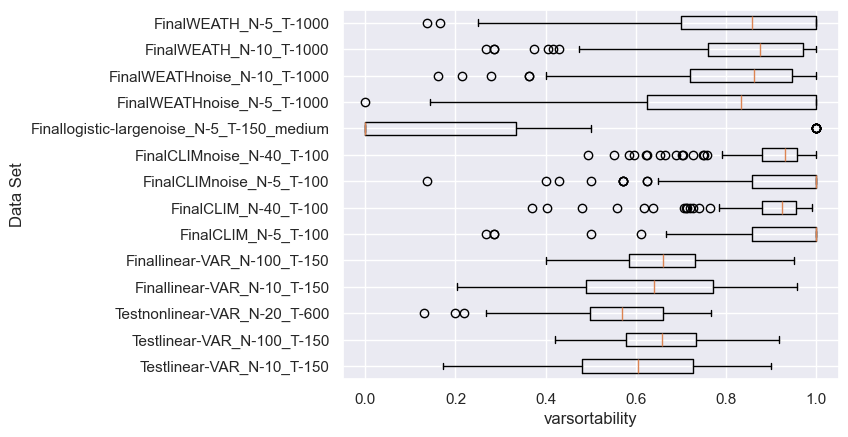

In [17]:


var_sorts_list = []
labels_list = []
for dataset in datasets:
    var_sorts_list.append(dataset["var_sorts"])

    # Extract the name after the last "/"
    label = os.path.basename(os.path.normpath(dataset["data"]))[:-1]
    labels_list.append(label)



box_plot = plt.boxplot(
    var_sorts_list, vert=False, labels=labels_list, patch_artist=False
)


plt.xlabel("varsortability")
plt.ylabel("Data Set")
plt.show()

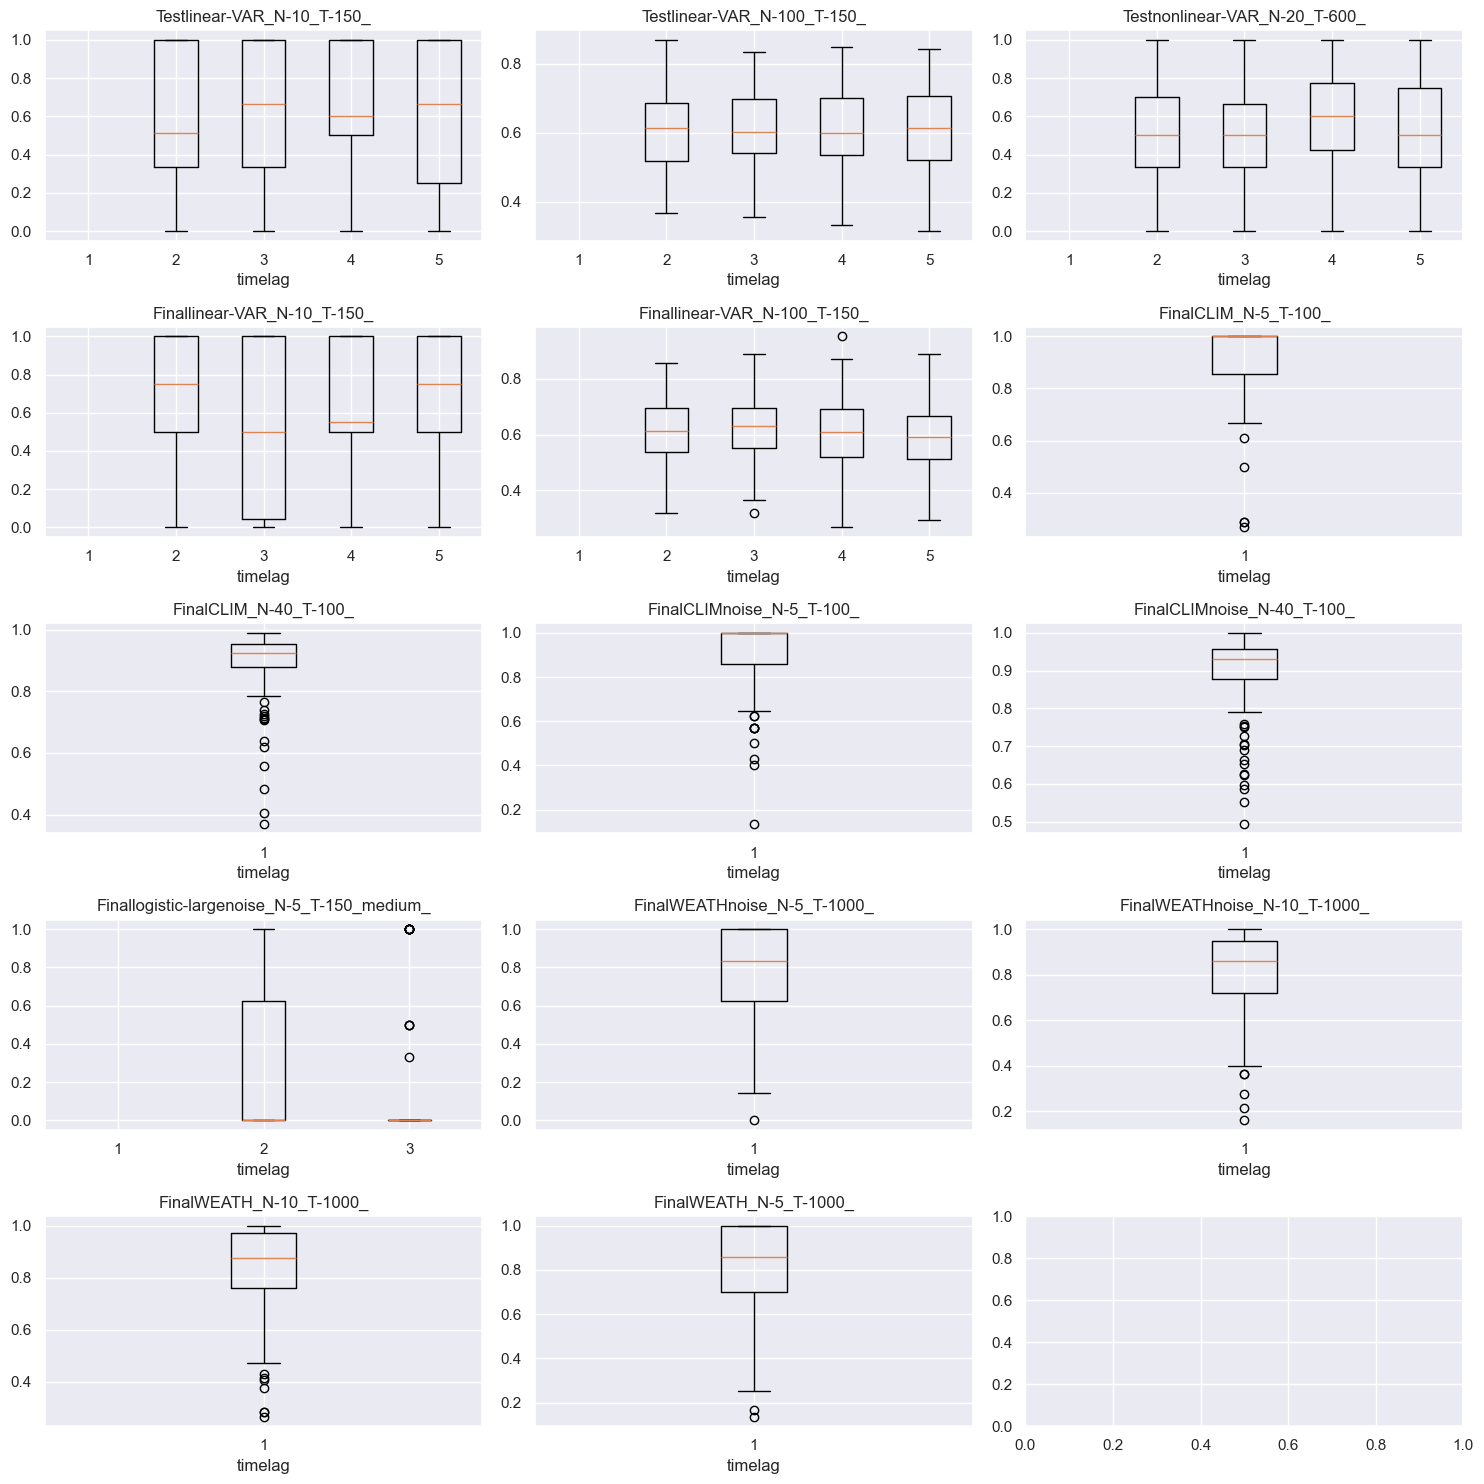

In [18]:

fig, axs = plt.subplots(5, 3, figsize=(15, 15))
axs = axs.flatten()

for i, dataset in enumerate(datasets):
    var_sorts_by_lag = dataset["var_sorts_by_lag"]
    mask = ~np.isnan(var_sorts_by_lag)
    filtered_data = [d[m] for d, m in zip(var_sorts_by_lag.T, mask.T)]
    label = os.path.basename(os.path.normpath(dataset["data"]))

    axs[i].boxplot(filtered_data)
    axs[i].set_title(label)
    axs[i].set_xlabel("timelag")

fig.tight_layout()

In [19]:
max_lags = 5  # Maximum number of lags

data = []

for i, dataset in enumerate(datasets):
    var_sorts_by_lag = dataset["var_sorts_by_lag"]
    mean_without_nan = np.nanmean(var_sorts_by_lag, axis=0)
    std = np.nanstd(var_sorts_by_lag, axis=0)

    # Fill up the missing lags with NaN values
    mean_without_nan = np.pad(
        mean_without_nan,
        (0, max_lags - len(mean_without_nan)),
        mode="constant",
        constant_values=np.nan,
    )
    std = np.pad(std, (0, max_lags - len(std)), mode="constant", constant_values=np.nan)
    label = os.path.basename(os.path.normpath(dataset["data"][:-1]))
    row_data = {"Dataset": label}
    for lag, (mean, std_dev) in enumerate(zip(mean_without_nan, std)):
        if not np.isnan(mean):
            row_data[f"Lag {lag}"] = f"${round(mean, 2)} \pm {round(std_dev, 2)}$"
        else:
            row_data[f"Lag {lag}"] = np.nan

    data.append(row_data)

df = pd.DataFrame(data)
df.replace(np.nan, "-", inplace=True) 
df

,Dataset,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4
0,Testlinear-VAR_N-10_T-150,-,$0.57 \pm 0.36$,$0.61 \pm 0.39$,$0.61 \pm 0.34$,$0.59 \pm 0.4$
1,Testlinear-VAR_N-100_T-150,-,$0.61 \pm 0.11$,$0.61 \pm 0.11$,$0.61 \pm 0.11$,$0.61 \pm 0.13$
2,Testnonlinear-VAR_N-20_T-600,-,$0.53 \pm 0.28$,$0.51 \pm 0.29$,$0.59 \pm 0.28$,$0.54 \pm 0.29$
3,Finallinear-VAR_N-10_T-150,-,$0.67 \pm 0.36$,$0.55 \pm 0.4$,$0.63 \pm 0.35$,$0.65 \pm 0.37$
4,Finallinear-VAR_N-100_T-150,-,$0.61 \pm 0.11$,$0.63 \pm 0.12$,$0.6 \pm 0.12$,$0.59 \pm 0.11$
5,FinalCLIM_N-5_T-100,$0.91 \pm 0.13$,-,-,-,-
6,FinalCLIM_N-40_T-100,$0.9 \pm 0.09$,-,-,-,-
7,FinalCLIMnoise_N-5_T-100,$0.91 \pm 0.13$,-,-,-,-
8,FinalCLIMnoise_N-40_T-100,$0.9 \pm 0.09$,-,-,-,-
9,Finallogistic-largenoise_N-5_T-150_medium,-,$0.26 \pm 0.43$,$0.19 \pm 0.37$,-,-


In [20]:
for dataset in datasets:
    ground_truth = dataset["ground_truth"]
    data = dataset["data"]
    N = dataset["N"]
    T = dataset["T"]
    iterations = dataset["iterations"]
    var_sorts, var_sorts_by_lag = get_var_sort(
        N, data, ground_truth, iterations, standardize=True
    )
    dataset["var_sorts_standardized"] = var_sorts

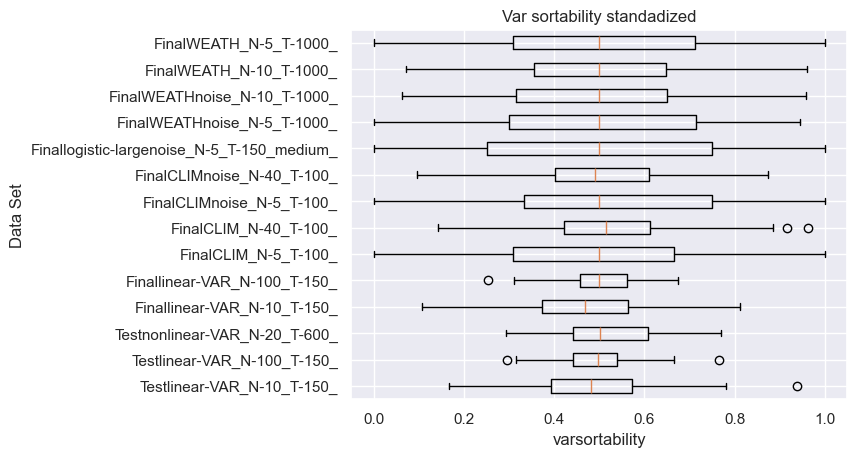

In [21]:
import os
import matplotlib.pyplot as plt

# Iterate through the list of dictionaries
var_sorts_list = []
labels_list = []
for dataset in datasets:
    var_sorts_list.append(dataset["var_sorts_standardized"])

    # Extract the name after the last "/"
    label = os.path.basename(os.path.normpath(dataset["data"]))
    labels_list.append(label)

box_plot = plt.boxplot(
    var_sorts_list, vert=False, labels=labels_list, patch_artist=False
)

plt.xlabel("varsortability")
plt.ylabel("Data Set")
plt.title("Var sortability standadized")
plt.show()

In [22]:
for dataset in datasets:
    ground_truth = dataset["ground_truth"]
    data = dataset["data"]
    N = dataset["N"]
    T = dataset["T"]
    iterations = dataset["iterations"]
    r2_sorts = get_r2_sort(N, data, ground_truth, iterations)
    dataset["r2_sorts"] = r2_sorts

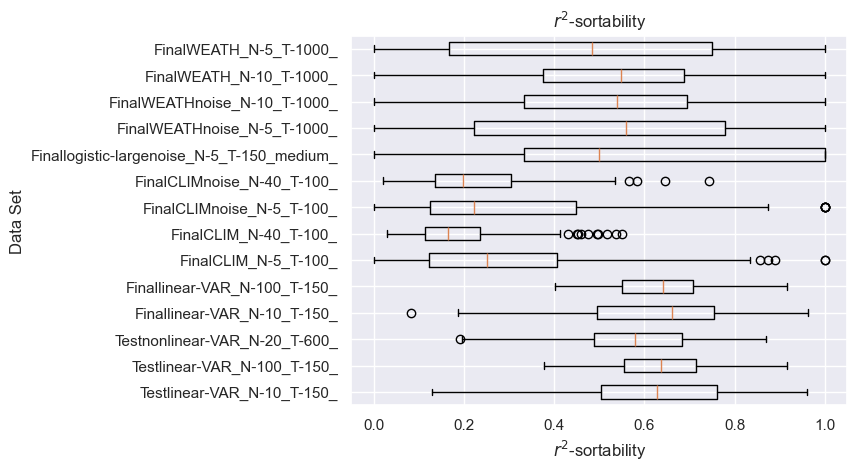

In [23]:
# Iterate through the list of dictionaries
var_sorts_list = []
labels_list = []
for dataset in datasets:
    var_sorts_list.append(dataset["r2_sorts"])

    # Extract the name after the last "/"
    label = os.path.basename(os.path.normpath(dataset["data"]))
    labels_list.append(label)

# Create the boxplot using the dynamically generated lists
plt.boxplot(var_sorts_list, vert=False, labels=labels_list)
plt.xlabel("$r^2$-sortability")
plt.ylabel("Data Set")
plt.title("$r^2$-sortability")
plt.show()

In [24]:
for dataset in datasets:
    ground_truth = dataset["ground_truth"]
    data = dataset["data"]
    N = dataset["N"]
    T = dataset["T"]
    iterations = dataset["iterations"]
    var_sorts = get_r2_sort(N, data, ground_truth, iterations, standardize=True)
    dataset["r2_sorts_standardized"] = var_sorts

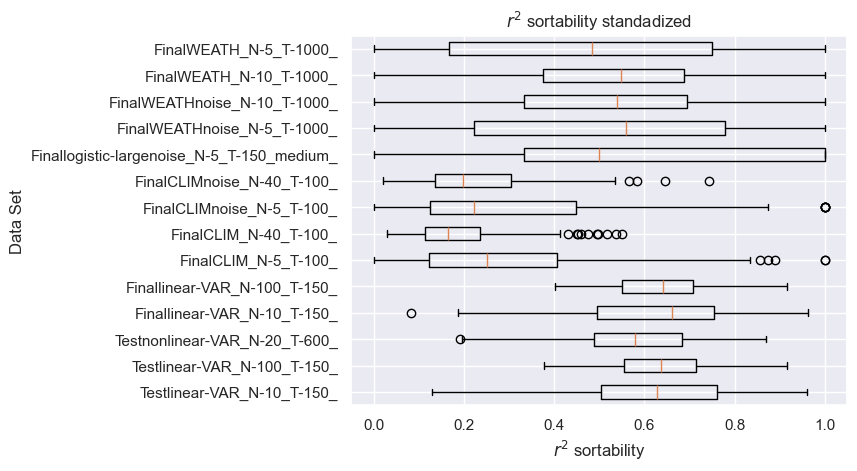

In [ ]:
var_sorts_list = []
labels_list = []
for dataset in datasets:
    var_sorts_list.append(dataset["r2_sorts_standardized"])

    # Extract the name after the last "/"
    label = os.path.basename(os.path.normpath(dataset["data"]))
    labels_list.append(label)

box_plot = plt.boxplot(
    var_sorts_list, vert=False, labels=labels_list, patch_artist=False
) 
plt.xlabel("$r^2$ sortability ")
plt.ylabel("Data Set")
plt.title("$r^2$ sortability standadized")
plt.show()

In [26]:

df = pd.DataFrame(datasets)

df["var_sorts_mean"] = df["var_sorts"].apply(lambda x: np.nanmean(x))

df["var_sorts_std"] = df["var_sorts"].apply(lambda x: np.nanstd(x))

df["r2_sorts_mean"] = df["r2_sorts"].apply(lambda x: np.nanmean(x))

df["r2_sorts_std"] = df["r2_sorts"].apply(lambda x: np.nanstd(x))

df = df[
    [
        "ground_truth",
        "var_sorts_mean",
        "var_sorts_std",
        "r2_sorts_mean",
        "r2_sorts_std",
    ]
]

df["ground_truth"] = df["ground_truth"].apply(lambda x: x.split("/")[-1])

df["ground_truth"] = df["ground_truth"].apply(lambda x: x.split(".json")[0])

df["var_sorts_mean"] = df["var_sorts_mean"].apply(lambda x: f"{round(x, 2)}")
df["var_sorts_std"] = df["var_sorts_std"].apply(lambda x: f"\pm{round(x, 2)}")
df["r2_sorts_mean"] = df["r2_sorts_mean"].apply(lambda x: f"{round(x, 2)}")
df["r2_sorts_std"] = df["r2_sorts_std"].apply(lambda x: f"\pm{round(x, 2)}")

df["var_sorts"] = df["var_sorts_mean"] + df["var_sorts_std"]
df["r2_sorts"] = df["r2_sorts_mean"] + df["r2_sorts_std"]


df = df.drop(
    columns=["var_sorts_mean", "var_sorts_std", "r2_sorts_mean", "r2_sorts_std"]
)

df["var_sorts"] = df["var_sorts"].apply(lambda x: f"${x}$")
df["r2_sorts"] = df["r2_sorts"].apply(lambda x: f"${x}$")

df

,ground_truth,var_sorts,r2_sorts
0,Testlinear-VAR_N-10_T-150,$0.59\pm0.17$,$0.61\pm0.19$
1,Testlinear-VAR_N-100_T-150,$0.65\pm0.11$,$0.64\pm0.12$
2,Testnonlinear-VAR_N-20_T-600,$0.56\pm0.13$,$0.57\pm0.14$
3,Finallinear-VAR_N-10_T-150,$0.62\pm0.18$,$0.62\pm0.18$
4,Finallinear-VAR_N-100_T-150,$0.66\pm0.11$,$0.63\pm0.11$
5,FinalCLIM_N-5_T-100,$0.91\pm0.13$,$0.29\pm0.25$
6,FinalCLIM_N-40_T-100,$0.9\pm0.09$,$0.19\pm0.11$
7,FinalCLIMnoise_N-5_T-100,$0.91\pm0.13$,$0.3\pm0.25$
8,FinalCLIMnoise_N-40_T-100,$0.9\pm0.09$,$0.23\pm0.13$
9,Finallogistic-largenoise_N-5_T-150_medium,$0.21\pm0.32$,$0.58\pm0.35$
